In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, LinearLocator, NullFormatter, NullLocator, MultipleLocator
import matplotlib.ticker
import matplotlib.colors
from matplotlib.font_manager import FontProperties
from matplotlib import rc, text
import astropy.coordinates as coord
import astropy.units as u
import scipy.stats
from astroquery.gaia import Gaia
from astropy.table import Table, unique, Column, hstack, vstack
import io
import pandas
from dustmaps.sfd import SFDQuery
from dustmaps.bayestar import BayestarQuery
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
def dust(ra, dec, distance, plot=False, max_samples=10, mode='median', model='bayes'):
    c = coord.SkyCoord(ra*u.deg, dec*u.deg, distance=distance*u.pc)
    sfd = SFDQuery()
    bayes = BayestarQuery(max_samples=max_samples)

    return sfd(c), bayes(c, mode=mode, return_flags=True) #, iphas(c, mode=mode), marshall(c), chen(c)
def getDust(G, bp, rp, ebv, maxnit=100):
    """ Compute the Gaia extinctions assuming relations from Babusieux
    Arguments: G, bp, rp, E(B-V)
    maxnit -- number of iterations
    Returns extinction in G,bp, rp
    Author: Sergey Koposov skoposov@cmu.edu
    """
    c1, c2, c3, c4, c5, c6, c7 = [0.9761, -0.1704,
                                  0.0086, 0.0011, -0.0438, 0.0013, 0.0099]
    d1, d2, d3, d4, d5, d6, d7 = [
        1.1517, -0.0871, -0.0333, 0.0173, -0.0230, 0.0006, 0.0043]
    e1, e2, e3, e4, e5, e6, e7 = [
        0.6104, -0.0170, -0.0026, -0.0017, -0.0078, 0.00005, 0.0006]
    A0 = 3.1*ebv
    P1 = np.poly1d([c1, c2, c3, c4][::-1])

    def F1(bprp): return np.poly1d(
        [c1, c2, c3, c4][::-1])(bprp)+c5*A0+c6*A0**2+c7*bprp*A0

    def F2(bprp): return np.poly1d(
        [d1, d2, d3, d4][::-1])(bprp)+d5*A0+d6*A0**2+d7*bprp*A0

    def F3(bprp): return np.poly1d(
        [e1, e2, e3, e4][::-1])(bprp)+e5*A0+e6*A0**2+e7*bprp*A0
    xind = np.isfinite(bp+rp+G)
    curbp = bp-rp
    for i in range(maxnit):
        AG = F1(curbp)*A0
        Abp = F2(curbp)*A0
        Arp = F3(curbp)*A0
        curbp1 = bp-rp-Abp+Arp

        delta = np.abs(curbp1-curbp)[xind]
        curbp = curbp1
    print(scipy.stats.scoreatpercentile(delta[np.isfinite(delta)], 99))
    AG = F1(curbp)*A0
    Abp = F2(curbp)*A0
    Arp = F3(curbp)*A0
    return AG, Abp, Arp

In [3]:
fig_width_pt = 245.27 #513.17           # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0      # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]

params = {'backend': 'pdf',
        'axes.labelsize': 7,
        'lines.markersize': 2,
        'font.size': 7,
        'xtick.major.size':6,
        'xtick.minor.size':3,  
        'ytick.major.size':6,
        'ytick.minor.size':3, 
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.0,
        'legend.fontsize': 7,
        'xtick.labelsize': 7,
        'ytick.labelsize': 7,
        'savefig.dpi':200,
        'path.simplify':True,
        'font.family': 'serif',
        'font.serif':'Times',
        'text.latex.preamble': [r'\usepackage{amsmath}'],
        'text.usetex':True,
        #'axes.color_cycle': ['b', 'lime', 'r', 'purple', 'g', 'c', 'm', 'orange', 'darkblue', \
        #                        'darkcyan', 'y','orangered','chartreuse','brown','deeppink','lightgreen', 'k'],
        #'font.serif':cm,
        'figure.figsize': fig_size}
plt.rcParams.update(params)

In [4]:
query = "SELECT TOP 10000 \
phot_g_mean_mag+5*log10(parallax)-10 AS mg, bp_rp FROM gaiaedr3.gaia_source \
WHERE parallax_over_error > 100 \
AND phot_g_mean_flux_over_error>50 \
AND phot_rp_mean_flux_over_error>20 \
AND phot_bp_mean_flux_over_error>20 \
AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2) \
AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2) \
AND visibility_periods_used>8 \
AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5))) \
AND (bp_rp > 2 \
OR phot_g_mean_mag+5*log10(parallax)-10 < 10+2.6*bp_rp)"

In [5]:
wd_query = "SELECT TOP 1000 \
phot_g_mean_mag+5*log10(parallax)-10 AS mg, bp_rp FROM gaiaedr3.gaia_source \
WHERE parallax_over_error > 20 \
AND phot_g_mean_flux_over_error>50 \
AND phot_rp_mean_flux_over_error>20 \
AND phot_bp_mean_flux_over_error>20 \
AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2) \
AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2) \
AND visibility_periods_used>8 \
AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5))) \
AND bp_rp < 2 \
AND phot_g_mean_mag+5*log10(parallax)-10 > 10+2.6*bp_rp"

In [6]:
job = Gaia.launch_job(query)
mainsequence = Table(job.get_results())

In [7]:
job = Gaia.launch_job(wd_query)
data = Table(job.get_results())

(17.0, -2.0)

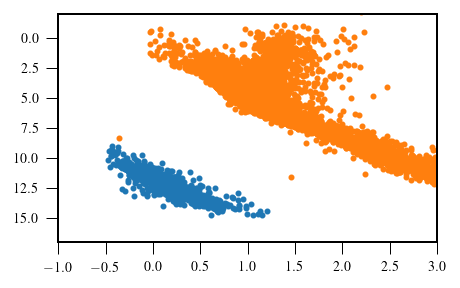

In [8]:
fig, ax1 = plt.subplots()
ax1.scatter(data['bp_rp'], data['mg'])
ax1.scatter(mainsequence['bp_rp'], mainsequence['mg'])
ax1.set_xlim([-1,3])
ax1.set_ylim([17,-2])

In [9]:
pulsar_data = np.genfromtxt('ipta_3arcsec_wpm-result.csv', delimiter=',', names=True, dtype=None)

/var/folders/bw/0h0f_0zs4z195525560spdjm0000gn/T/ipykernel_91110/422673390.py:1: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  pulsar_data = np.genfromtxt('ipta_3arcsec_wpm-result.csv', delimiter=',', names=True, dtype=None)


In [10]:
pulsar_data = Table(pulsar_data)
pulsar_data.sort(['names', 'angdist'])
#pulsar_data = unique(pulsar_data, keys='names') # don't drop duplicates, J1747

In [11]:
pulsar_data

solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat,pulsars_oid,angdist,names,ra_1,dec_1,pmra_1,pmdec_1,dm,pepoch,posepoch,dmepoch,ra_epoch2000,dec_epoch2000,errhalfmaj,errhalfmin,errposang
float64,bytes29,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,int64,bool,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,int64,int64,int64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,int64,int64,int64,int64,float64,float64,float64,float64,bool,bool,int64,bool,bool,bool,float64,float64,float64,float64,int64,float64,bytes10,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,int64
1.63604e+18,Gaia EDR3 4789864076732331648,4.78986e+18,299311299,2016,69.31662758,0.45911273,-47.25268764,0.5165178,7.100758956,0.52452594,13.537479,140.69727,121.6455402,0.5740319,-70.69711408,0.64981335,-0.007737055,0.34502465,0.009485758,0.090481654,0.18195024,0.23813902,-0.51167303,0.28137034,-0.14777644,-0.22096139,262,0,262,0,-0.8101223,252.68391,0.0,0.0,95,False,nan,1.5331504,0.14090222,-0.036248896,-0.09184883,-0.19217344,-0.12727512,0.20658779,30,23,0.99918807,33,12,0,0.016796837,168.20538,0,0,0.96312565,0.077873945,0.09261617,0.10425211,0.10953399,-105.256134,66.05753,-41.108833,38.974846,False,264,136.5985603,0.79324865,172.20145,20.348751,21,69.58137783,11.601847,5.99744,20.73231,31,117.6922439,9.431108,12.479153,19.571026,0,0,0,1,0,1.370978,1.1612835,0.38355827,0.7777252,False,False,0,False,False,False,253.3946414,-41.96311926,50.4687711,-67.87317176,1,2.129479,J0437-4715,69.31657748,-47.25266789,121.4365031,-71.46610114,55000,55000,55000,2.644943631,69.31582342,-47.25237136,0.026,0.019,0
1.63604e+18,Gaia EDR3 3118031701531604992,3.11803e+18,1168651342,2016,93.43200198,0.17373401,-2.013173328,0.1952674,0.036512664,0.1674093,0.21810415,1.999696,0.814501488,0.27787367,-1.826299909,0.

In [12]:
df = pandas.DataFrame(data=pulsar_data['names'])

names_keep = ['J0437-4715', 'J1012+5307', 'J1024-0719', 'J1732-5049', 'J1747-4036', 'J1843-1113']#, 'J1955+2908']
pulsar_data = pulsar_data[np.isin((df['names'].str.decode("utf-8")), names_keep)] # keep only the sources we wrote about

In [13]:
df = pandas.DataFrame(data=pulsar_data['designation'])
#cut by designation for only the matches in the paper
objects_keep = ['Gaia EDR3 4789864076732331648', 'Gaia EDR3 851610861391010944', 'Gaia EDR3 3775277872387310208', 'Gaia EDR3 5946288492263176704', 'Gaia EDR3 5957827763757710080', 'Gaia EDR3 5957827763757708544', 'Gaia EDR3 4106823440438736384']
pulsar_data = pulsar_data[np.isin((df['designation'].str.decode("utf-8")), objects_keep)] # keep only the sources we wrote ab


In [14]:
pulsar_data

solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat,pulsars_oid,angdist,names,ra_1,dec_1,pmra_1,pmdec_1,dm,pepoch,posepoch,dmepoch,ra_epoch2000,dec_epoch2000,errhalfmaj,errhalfmin,errposang
float64,bytes29,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,int64,bool,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,int64,int64,int64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,int64,int64,int64,int64,float64,float64,float64,float64,bool,bool,int64,bool,bool,bool,float64,float64,float64,float64,int64,float64,bytes10,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,int64
1.63604e+18,Gaia EDR3 4789864076732331648,4.78986e+18,299311299,2016,69.31662758,0.45911273,-47.25268764,0.5165178,7.100758956,0.52452594,13.537479,140.69727,121.6455402,0.5740319,-70.69711408,0.64981335,-0.007737055,0.34502465,0.009485758,0.090481654,0.18195024,0.23813902,-0.51167303,0.28137034,-0.14777644,-0.22096139,262,0,262,0,-0.8101223,252.68391,0.0,0.0,95,False,nan,1.5331504,0.14090222,-0.036248896,-0.09184883,-0.19217344,-0.12727512,0.20658779,30,23,0.99918807,33,12,0,0.016796837,168.20538,0,0,0.96312565,0.077873945,0.09261617,0.10425211,0.10953399,-105.256134,66.05753,-41.108833,38.974846,False,264,136.5985603,0.79324865,172.20145,20.348751,21,69.58137783,11.601847,5.99744,20.73231,31,117.6922439,9.431108,12.479153,19.571026,0,0,0,1,0,1.370978,1.1612835,0.38355827,0.7777252,False,False,0,False,False,False,253.3946414,-41.96311926,50.4687711,-67.87317176,1,2.129479,J0437-4715,69.31657748,-47.25266789,121.4365031,-71.46610114,55000,55000,55000,2.644943631,69.31582342,-47.25237136,0.026,0.019,0
1.63604e+18,Gaia EDR3 851610861391010944,8.51611e+17,936108977,2016,153.1393309,0.20425898,53.11725939,0.20397721,1.744756918,0.29057664,6.004464,26.06516,2.736445099,0.2918446,-25.92112075,0.2705

In [15]:
#use combined distances
pulsar_data.add_column(['distance'])
pulsar_data.add_column(['distance_low'])
pulsar_data.add_column(['distance_high'])
distance =      [157,    837.2, 1013.5, 4210, 1099, 1104, 1619]
distance_high = [157.1,  861.8, 1288.0, 6176, 1676, 1677, 2198]
distance_low =  [156.5,  781.7, 745.6,  2076, 649,  651,  1102]
pulsar_data['distance']=distance
pulsar_data['distance_low']=distance_low
pulsar_data['distance_high']=distance_high

In [16]:
pulsar_data['mg'] = pulsar_data['phot_g_mean_mag']*u.mag - coord.Distance(pulsar_data['distance']*u.pc).distmod
pulsar_data['mg_lo'] = pulsar_data['phot_g_mean_mag']*u.mag - coord.Distance(pulsar_data['distance_high']*u.pc).distmod
pulsar_data['mg_hi'] = pulsar_data['phot_g_mean_mag']*u.mag - coord.Distance(pulsar_data['distance_low']*u.pc).distmod
mg_err = np.vstack((np.abs(pulsar_data['mg_lo'] - pulsar_data['mg']), 
                    np.abs(pulsar_data['mg_hi'] - pulsar_data['mg'])))
color_err = np.sqrt((2.5 / np.log(10)*pulsar_data['phot_bp_mean_flux_error']/pulsar_data['phot_bp_mean_flux'])**2 + 
                    (2.5 / np.log(10)*pulsar_data['phot_rp_mean_flux_error']/pulsar_data['phot_rp_mean_flux'])**2)

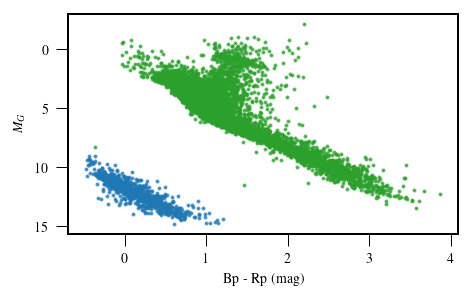

In [17]:
fig, ax1 = plt.subplots()
ax1.scatter(data['bp_rp'], data['mg'], color='C0', alpha=0.7, s=1)
ax1.scatter(mainsequence['bp_rp'], mainsequence['mg'], color='C2', alpha=0.7, s=1)
ax1.invert_yaxis()
ax1.set_xlabel('Bp - Rp (mag)')
ax1.set_ylabel('$M_G$')
bprp = pulsar_data['bp_rp']
absG = pulsar_data['mg']
plt.tight_layout()
#plt.savefig("../figures/hrd_wLabels-cm.pdf")

In [20]:
sfd, bayesMid = dust(pulsar_data['ra'], pulsar_data['dec'], pulsar_data['distance'])
sfdAG, sfdAbp, sfdArp = getDust(pulsar_data['phot_g_mean_mag'], pulsar_data['phot_bp_mean_mag'], pulsar_data['phot_rp_mean_mag'], sfd)
bayesAG, bayesAbp, bayesArp = getDust(pulsar_data['phot_g_mean_mag'], pulsar_data['phot_bp_mean_mag'], pulsar_data['phot_rp_mean_mag'],bayesMid[0])

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 30.731 s
  pix_info:   0.465 s
   samples:  21.124 s
      best:   3.856 s
       nan:   0.051 s
      sort:   5.159 s
       idx:   0.076 s
0.0
0.0


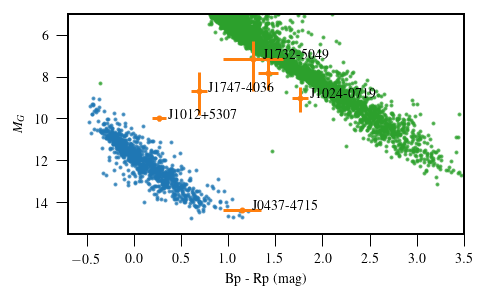

In [21]:
bestAG = bayesAG
bestAG[np.isnan(bestAG)] = sfdAG[np.isnan(bestAG)]
bestArp = bayesArp
bestArp[np.isnan(bestArp)] = sfdArp[np.isnan(bestArp)]
bestAbp = bayesAbp
bestAbp[np.isnan(bestAbp)] = sfdAbp[np.isnan(bestAbp)]
fig, ax1 = plt.subplots()
bprp = pulsar_data['bp_rp'] - bestAbp + bestArp
absG = pulsar_data['mg'] - bestAG
ax1.scatter(data['bp_rp'], data['mg'], color='C0', alpha=0.7, s=1)
ax1.scatter(mainsequence['bp_rp'], mainsequence['mg'], color='C2', alpha=0.7, s=1)
ax1.errorbar(pulsar_data['bp_rp'] - bestAbp + bestArp, pulsar_data['mg'] - bestAG, yerr=mg_err, xerr=color_err, color='C1', fmt='o')
ax1.set_xlim([-.7,3.5])
ax1.set_ylim([15.5,5])
#ax1.invert_yaxis()
ax1.set_xlabel('Bp - Rp (mag)')
ax1.set_ylabel('$M_G$')
for ii in range(6):
    ax1.annotate(pulsar_data['names'][ii], (bprp[ii]+0.1, absG[ii]), color = 'black')
#for i in range(len(pulsar_data['names'])):
 #   ax1.annotate(pulsar_data['names'][i], (bprp[i]+0.1, absG[i]), color = 'black')

plt.tight_layout()
plt.savefig("hrd_wLabels_wDust.pdf")

In [22]:
import matplotlib as mpl
import copy

In [25]:
labels = ['J0437-4715', 'J1012+5307', 'J1024-0719', 'J1732-5049', 'J1747-4036, Obj B', 'J1747-4036, A', 'J1843-1113']

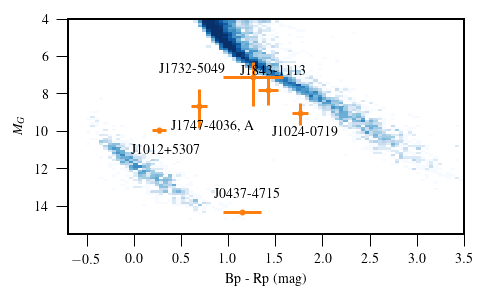

In [26]:
bestAG = bayesAG
bestAG[np.isnan(bestAG)] = sfdAG[np.isnan(bestAG)]
bestArp = bayesArp
bestArp[np.isnan(bestArp)] = sfdArp[np.isnan(bestArp)]
bestAbp = bayesAbp
bestAbp[np.isnan(bestAbp)] = sfdAbp[np.isnan(bestAbp)]
fig, ax1 = plt.subplots()

bprp = pulsar_data['bp_rp'] - bestAbp + bestArp
absG = pulsar_data['mg'] - bestAG

nbins = 100
xbins = np.linspace(-1, 3.5, nbins)
ybins = np.linspace(4, 16, nbins)
alldata = vstack((mainsequence, data))
H, xe, ye = np.histogram2d(alldata['bp_rp'], alldata['mg'], bins=(xbins, ybins))
map = copy.copy(mpl.cm.get_cmap("Blues"))
#cmapchosen.set_under(color='white')
cmapchosen = plt.get_cmap('Blues')
cmapchosen.set_under(color='white')
im = ax1.pcolormesh(xe, ye, H.T + 1,
      norm=mpl.colors.LogNorm(), cmap=cmapchosen, vmax=40, vmin=2)#vmax=75))#, vmax=20) #, vmin=-100, vmax=100)
im.set_rasterized(True)

ax1.errorbar(pulsar_data['bp_rp'] - bestAbp + bestArp, pulsar_data['mg'] - bestAG, yerr=mg_err, xerr=color_err, color='C1', fmt='o')
ax1.set_xlim([-.7,3.5])
ax1.set_ylim([15.5,4])

ax1.set_xlabel('Bp - Rp (mag)')
ax1.set_ylabel('$M_G$')

for i in range(7):
    if pulsar_data['designation'][i] in ['Gaia EDR3 4789864076732331648', 'Gaia EDR3 4106823440438736384']: x = bprp[i] - 0.3; y = absG[i] - 0.8
    elif pulsar_data['designation'][i] in ['Gaia EDR3 5946288492263176704']: x = bprp[i] - 1.; y = absG[i] - 0.2
    else: x = bprp[i] - 0.3; y = absG[i] + 1.25
    ax1.annotate(labels[i], (x, y), color = 'black')

plt.tight_layout()
plt.savefig("hrd_wLabels_wDust_hist.pdf")

#note that 544 does not show bc some photo data is missing


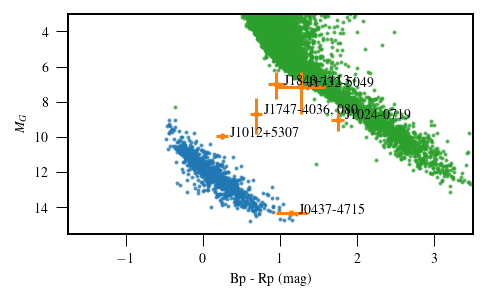

In [112]:
bestAG = sfdAG
bestAG[np.isnan(bestAG)] = bayesAG[np.isnan(bestAG)]
bestArp = sfdArp
bestArp[np.isnan(bestArp)] = bayesArp[np.isnan(bestArp)]
bestAbp = sfdAbp
bestAbp[np.isnan(bestAbp)] = bayesAbp[np.isnan(bestAbp)]
fig, ax1 = plt.subplots()
bprp = pulsar_data['bp_rp'] - bestAbp + bestArp
absG = pulsar_data['mg'] - bestAG
ax1.scatter(data['bp_rp'], data['mg'], color='C0', alpha=0.7, s=1)
ax1.scatter(mainsequence['bp_rp'], mainsequence['mg'], color='C2', alpha=0.7, s=1)
ax1.errorbar(bprp, absG, yerr=mg_err, xerr=color_err,color='C1', fmt='o')
ax1.set_xlim([-1.75,3.5])
ax1.set_ylim([15.5,3])
#ax1.invert_yaxis()
ax1.set_xlabel('Bp - Rp (mag)')
ax1.set_ylabel('$M_G$')
for i in range(7):
    ax1.annotate(labels[i], (bprp[i]+0.1, absG[i]), color = 'black')
plt.tight_layout()
plt.savefig("rd_wLabels_wDustSFD.pdf")